# Music Generation

https://www.kaggle.com/code/karnikakapoor/music-generation-lstm/notebook#IMPORTING-LIBRARIES

## Libraries

In [1]:
# pip install music21

In [2]:
import numpy as np
import pandas as pd

import sys
import os

import music21
from music21 import *

import IPython
from IPython.display import Image, Audio

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from keras.models import load_model

In [3]:
# pip install protobuf==3.19.0

## Loading Data

Data source: http://www.piano-midi.de/

Why MIDI? 

Advantages of MIDI include small file size, ease of modification and manipulation and a wide choice of electronic instruments and synthesizer or digitally sampled sounds.

1. Make a list of all the songs in the Beethoven folder.
2. Create a function to extract chords and notes out of the data creating a corpus

In [4]:
%%time

filepath = "Data/beeth/"

all_midis = []
for i in os.listdir(filepath): #import OS
    if i.endswith(".mid"):
        tr = filepath + i
        midi = converter.parse(tr) #from music21 import*
        all_midis.append(midi)

CPU times: total: 36.5 s
Wall time: 42.2 s


In [5]:
all_midis

[<music21.stream.Score 0x1a4a32fdc40>,
 <music21.stream.Score 0x1a4b8d267f0>,
 <music21.stream.Score 0x1a4a32fde20>,
 <music21.stream.Score 0x1a4be0d5160>,
 <music21.stream.Score 0x1a4c1860940>,
 <music21.stream.Score 0x1a4c18f28b0>,
 <music21.stream.Score 0x1a4c47cb400>,
 <music21.stream.Score 0x1a4bcc876a0>,
 <music21.stream.Score 0x1a4c5f0a490>,
 <music21.stream.Score 0x1a4c56465b0>,
 <music21.stream.Score 0x1a4cd9498e0>,
 <music21.stream.Score 0x1a4cf32efd0>,
 <music21.stream.Score 0x1a4cfa51fa0>,
 <music21.stream.Score 0x1a4d0238520>,
 <music21.stream.Score 0x1a4d4ed8d00>,
 <music21.stream.Score 0x1a4d519ea60>,
 <music21.stream.Score 0x1a4d593ca00>,
 <music21.stream.Score 0x1a4d6454130>,
 <music21.stream.Score 0x1a4d8b14820>,
 <music21.stream.Score 0x1a4db2256d0>,
 <music21.stream.Score 0x1a4db619250>,
 <music21.stream.Score 0x1a4db23ca00>,
 <music21.stream.Score 0x1a4dd492b20>,
 <music21.stream.Score 0x1a4dd075d30>,
 <music21.stream.Score 0x1a4e3e34df0>,
 <music21.stream.Score 0x

Above music21 stream contains chords which is made of different notes.

**Note:** Basic building block associated with specific vibration. There are 12 notes in western music

**Chord:** A group of notes that sounds good together

3. Get the notes and chords out of the MIDI files.

In [6]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j) #partition into a Part for each unique Instrument
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
    return notes

In [7]:
Corpus = extract_notes(all_midis)
print("Total notes:", len(Corpus))

Total notes: 81312


Data in now in the form of a corpus (collection of strings, in this case, notes and chords).

## Data Exploration

* Explore the data Corpus
* Examine the notes
* Simplify Corpus to built a working model

In [8]:
# First few values in the Corpus
Corpus[:30]

['C4',
 'C2',
 'G#3',
 'G#1',
 'F3',
 'F1',
 'G#3',
 'G#1',
 'C4',
 'C2',
 'F4',
 'F2',
 'G#4',
 'G#2',
 'C5',
 'C3',
 'F5',
 'F3',
 'F4',
 'G#3',
 'C5',
 '0.4.7',
 'D5',
 '0.2',
 '5.8.11',
 '2.4',
 '2.4',
 '2.4',
 '2.4',
 '2.4']

Above are the music notes.

`G5`, `F#5`, etc are notes.

`2.6.9`, `9.2`, etc are chords.

### Create Music Sheet

In [9]:
def show(music):
    display(Image(str(music.write("lily.png")))) #from IPython.display import Image, Audio
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0
    for i in Snippet:
        if ("." in i or i.isdigit()): # if chord
            chord_notes = i.split(".") # split into notes
            notes = []
            for j in chord_notes:
                inst_note = int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset # so that notes dont stack
                Melody.append(chord_snip)
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

In [10]:
# us = environment.UserSettings()
# us.create()
# us['lilypondPath'] = r'LilyPond\usr\bin\lilypond.exe'

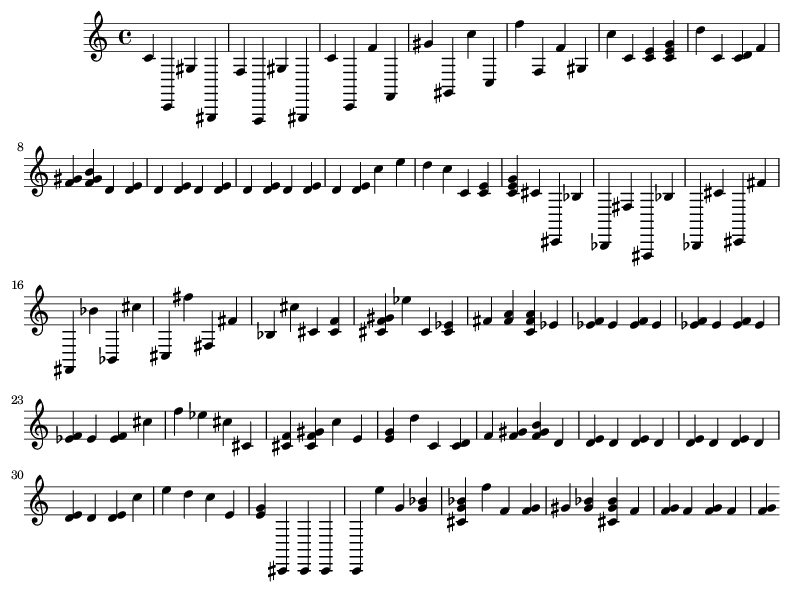

In [11]:
Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

### Examine the notes in the Corpus

In [12]:
#Creating a count dictionary
count_num = Counter(Corpus) # from collections import Counter
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 349


In [13]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())

#Average recurrence for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)

print("Average recurrence for a note in Corpus:", round(Average(Recurrence)), "times.")
print("Most frequent note in Corpus appeared:", max(Recurrence), "times.")
print("Least frequent note in Corpus appeared:", min(Recurrence), "times.")

Average recurrence for a note in Corpus: 233 times.
Most frequent note in Corpus appeared: 2094 times.
Least frequent note in Corpus appeared: 1 times.


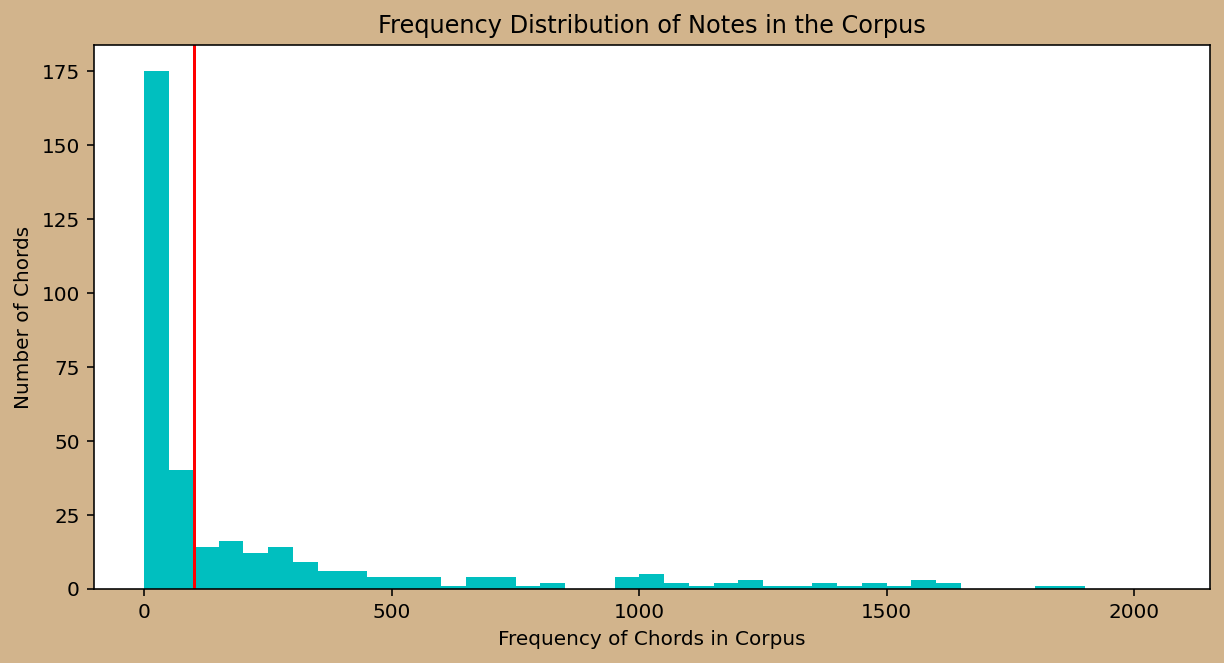

In [14]:
# Plotting the distribution of Notes
plt.figure(figsize=(10, 5), facecolor="tan")
bins = np.arange(0, (max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="c")
plt.axvline(x=100, color="r")
plt.title("Frequency Distribution of Notes in the Corpus")
plt.xlabel("Frequency of Chords in Corpus")
plt.ylabel("Number of Chords")
plt.show()

### Filtering out rare notes (played less than 100 times)

In [15]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m = key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 215


In [16]:
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)
        
print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 77579


## Data Preprocessing

Steps
* Creating a notes Dictionary
* Encoding and splitting the corpus
* Assigning X and y
* Splitting Train and Seed datasets

### Creating a notes dictionary
Creating a dictionary to map the notes and their indices. We have the note's name as a string the Corpus. For the computer, these names are just a symbol. So we create a dictionary to map each unique note in our Corpus to a number. And vice versa to retrieve the values at the time of prediction. This will be used to encode and decode the information going in and getting out of the RNN.

In [17]:
# Storing all the unique characters present in my corpus to built a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus)
L_symb = len(symb)

# Building dictionary to access the vocabulary from indices and vice cersa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 77579
Number of unique characters: 253


### Encoding and splitting the corpus

Encoding and splitting the corpus into smaller sequences of equal length: At this point, the Corpus contain notes. We will encode this corpus and create small sequences of equal lemgths of features and the corresponding targets. Each feature and target will contain the maped index in the dicitonary of the unique characters they signify.

In [18]:
# Splitting the corpus in eqyal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

L_datapoints = len(targets)
print("Total number of sequences in th Corpus:", L_datapoints)

Total number of sequences in th Corpus: 77539


### Asigning X and y
The labels are then resized and normalized. Whereas the targets are one-hot encoded. Ready to be sent to the RNN for the training, but before that let us built the RNN model.

In [19]:
# reshape X nd normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/float(L_symb)

In [20]:
# one hot encode the output cariable
y = tensorflow.keras.utils.to_categorical(targets)

### Splitting Train and Seed datasets
To create music, we will need to send some input to the RNN. For that, we will set aside a part of the data as seeds. We could have trained it all but I am no musician to come up with an input seed value.

In [21]:
# Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Building

### LSTM Model

Steps
* Initialising the Model
* Defining by adding layers
* Compiling the Model
* Training the Model

Note: Optimier Adamax is introduced as special case of adam where its seconod-order moment v0 is replaced by infinite-order moment. The infinite-order norm makes the algorithm surprisingly stable.

#### Building the Model

In [22]:
# Initializing the Model
model = Sequential()

# Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))

#Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [23]:
# Model's summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 253)               65021     
                                                                 
Total params: 1,970,941
Trainable params: 1,970,941
Non-

In [24]:
# history = model.fit(X_train, y_train, batch_size=256, epochs=200)

#### Saving and loading the model

In [25]:
# saving model
# model.save('model_01.h5')

#deletes existing model
# del model

In [26]:
# Loading model
model = load_model('model_01.h5')

In [27]:
history = model

### Model Evaluation

* Check the performance of the model via Learning Curves
* Evaluate the melody created

#### Plotting the learning curve for the loss function

In [28]:
# history_df = pd.DataFrame(history.history)
# fig = plt.figure(figsize=(15, 4), facecolor = "tan")
# fig.suptitle("Learning Plot of Model for Loss")
# pl = sns.lineplot(data=history_df["loss"], color="c")
# pl.set(ylabel = "Training Loss")
# pl.set(xlabel = "Epochs")

In [29]:
# history_df

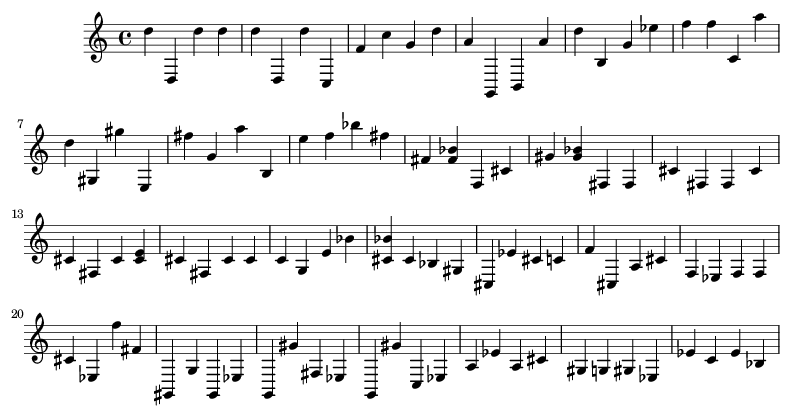

In [30]:
def Melody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Melody_Generator(100)
show(Melody)

In [31]:
#To save the generated melody
Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'

In [22]:
song_1 = "Melody_Generated.mid"
pygame.mixer.music.load(song_1)
pygame.mixer.music.play()

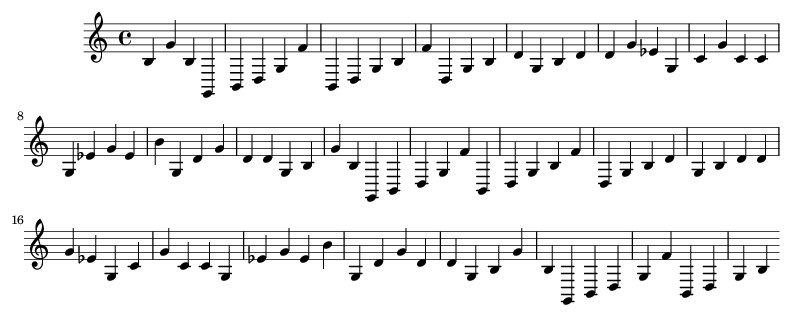

In [33]:
Music_notes, Melody = Melody_Generator(90)
show(Melody)

In [34]:
Melody.write('midi','Melody_Generated_01.mid')

'Melody_Generated_01.mid'

In [21]:
song_1 = "Melody_Generated_01.mid"
pygame.mixer.music.load(song_1)
pygame.mixer.music.play()